# Brain Tumor Classification 

## 1. Project Overview And Objectives



## 2. What is brain tumor?

A brain tumor is a mass or growth of abnormal cells in your brain.

Many different types of brain tumors exist. Some brain tumors are noncancerous (benign), and some brain tumors are cancerous (malignant). Brain tumors can begin in your brain (primary brain tumors), or cancer can begin in other parts of your body and spread to your brain as secondary (metastatic) brain tumors.

How quickly a brain tumor grows can vary greatly. The growth rate as well as the location of a brain tumor determines how it will affect the function of your nervous system.

Brain tumor treatment options depend on the type of brain tumor you have, as well as its size and location.

Source: [Mayoclinic](https://www.mayoclinic.org/diseases-conditions/brain-tumor/symptoms-causes/syc-20350084#:~:text=A%20brain%20tumor%20is%20a,tumors%20are%20cancerous%20(malignant))

<p>
    <img src="mcdc7_brain_cancer-8col.webp" width="200px">
    <em>Brain tumor Example</em>
</p>

## 3. Dataset

https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection

## 4. Import Necessary Packages

In [1]:
import numpy as np
import cv2
import os
import shutil
import itertools
import imutils
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras import layers, models
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications import ResNet101
from keras.applications import DenseNet201, DenseNet169, DenseNet121
from keras.applications import InceptionV3
from keras.applications import InceptionResNetV2
from keras.applications import Xception
from keras.applications import MobileNetV2
from keras.applications import MobileNet
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
import pandas as pd

init_notebook_mode(connected=True)
RANDOM_SEED = 123

Using TensorFlow backend.


## 5. Data Preprocessing 

In [2]:
imgPath = 'brain_tumor_dataset/'
imgPathYes = 'brain_tumor_dataset/yes/'
imgPathNo = 'brain_tumor_dataset/no/'
print(len(os.listdir(imgPathYes)))
print(len(os.listdir(imgPathNo)))

155
98


In [14]:
os.mkdir('splitted_brain_tumor_dataset/')
os.mkdir('splitted_brain_tumor_dataset/train')
os.mkdir('splitted_brain_tumor_dataset/validation/')
#os.mkdir('splitted_brain_tumor_dataset/test/')
os.mkdir('splitted_brain_tumor_dataset/train/yes/')
os.mkdir('splitted_brain_tumor_dataset/train/no/')
os.mkdir('splitted_brain_tumor_dataset/validation/yes/')
os.mkdir('splitted_brain_tumor_dataset/validation/no/')
#os.mkdir('splitted_brain_tumor_dataset/test/yes/')
#os.mkdir('splitted_brain_tumor_dataset/test/no/')

In [15]:
train_path = 'splitted_brain_tumor_dataset/train/'
#test_path = 'splitted_brain_tumor_dataset/test/'
val_path = 'splitted_brain_tumor_dataset/validation/'

def split_dataset(dataset):
    for class_label in os.listdir(dataset):
        num_images = len(os.listdir(os.path.join(dataset, class_label)))
        img_list = os.listdir(os.path.join(dataset, class_label))
        for n, img in enumerate(img_list):
            if n < num_images*0.8:
                shutil.copy(os.path.join(dataset, class_label,img), train_path + class_label)
            else:
                shutil.copy(os.path.join(dataset, class_label,img), val_path + class_label)
        
    


In [16]:
split_dataset('brain_tumor_dataset')

In [18]:
print(len(os.listdir(train_path)))
print(len(os.listdir(val_path)))

2
2


In [19]:
def get_size(dataset):
    
    img_shapes = []
    for img in os.listdir(dataset):
        img = cv2.imread(os.path.join(dataset,img))
        #print(img.shape[:2])
        img_shapes.append(img.shape[:2])
    return img_shapes

In [20]:
img_shapes = get_size('splitted_brain_tumor_dataset/train/no/')
pd.Series(img_shapes).value_counts()[:5]

(225, 225)    16
(630, 630)     4
(168, 300)     3
(251, 201)     3
(217, 232)     3
dtype: int64

## 6. Data Augmentation

In [23]:
train_datagen = ImageDataGenerator(rescale = 1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True)
      
val_datagen = ImageDataGenerator(rescale=1./255)

#test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_path,
                                                   target_size=(150, 150),
                                                   batch_size=20,
                                                   class_mode='binary')

val_generator = val_datagen.flow_from_directory(val_path,
                                                  target_size=(150, 150),
                                                  batch_size=20,
                                                  class_mode='binary')

# test_generator = test_datagen.flow_from_directory(test_path,
  #                                               target_size=(150, 150),
   #                                              batch_size=1,
    #                                             class_mode='binary')'''

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


## 7.Training on Pre-Trained Models

In [10]:
nets_evaluation_df = pd.DataFrame(columns=['Training Accuracy', 'Validation Accuracy', 'Test Accuracy', 'F1 Measure', 'Kappa', 'ROC Area', 'Confusion Matrix'])
EPOCHS = 30
IMG_SIZE = (150, 150)
NUM_CLASSES = 1
trained_nets = {VGG16 : 'VGG16', VGG19 : 'VGG19',  ResNet50 : 'ResNet50', ResNet101 : 'ResNet101', DenseNet201 : 'DenseNet201',
               DenseNet169 : 'DenseNet169', DenseNet121 : 'DenseNet121', InceptionV3 : 'InceptionV3', InceptionResNetV2 : 'InceptionResNetV2',
               Xception : 'Xception', MobileNetV2 : 'MobileNetV2', MobileNet : 'MobileNet'}

In [25]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, cohen_kappa_score

y_test = val_generator.classes

for net in trained_nets.keys():
    # loading base model
    base_model = net(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SIZE + (3,))
    
    

    model= Sequential()
    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

    model.layers[0].trainable = False

    model.compile(
        loss='binary_crossentropy',
        optimizer=RMSprop(lr=1e-4),
        metrics=['accuracy'])

    #model.summary()
    
    
    history = model.fit(
                    train_generator, steps_per_epoch=len(train_generator),
                    epochs=EPOCHS, validation_data=val_generator,
                    validation_steps=len(val_generator))
    
    # validate on test set    
    # predictions = model.predict(X_test_prep)
    # predictions = [1 if x>0.5 else 0 for x in predictions]
    
    predictions = model.predict_generator(val_generator,steps = len(val_generator))
    predictions = [1 if x>0.5 else 0 for x in predictions]

    acc = history.history['accuracy']
    
    val_acc = history.history['val_accuracy']

    test_accuracy = accuracy_score(y_test, predictions)

    kappa_score = cohen_kappa_score(y_test, predictions)

    roc_area = roc_auc_score(y_test, predictions)

    (precision, recall, fscore, support) = precision_recall_fscore_support(y_test, predictions, average='macro')
    
    confusion_mtrx = confusion_matrix(y_test, predictions)
    
    measures = [acc[-1], val_acc[-1], test_accuracy, fscore, kappa_score, roc_area, confusion_mtrx]

    nets_evaluation_df.loc[trained_nets[net]] = measures

Epoch 1/30
11/11 [==============================] - 3s 248ms/step - loss: 0.7311 - accuracy: 0.5271 - val_loss: 0.6163 - val_accuracy: 0.6000
Epoch 2/30
11/11 [==============================] - 1s 100ms/step - loss: 0.7099 - accuracy: 0.5616 - val_loss: 0.6358 - val_accuracy: 0.6000
Epoch 3/30
11/11 [==============================] - 1s 134ms/step - loss: 0.6607 - accuracy: 0.6355 - val_loss: 0.5243 - val_accuracy: 0.6200
Epoch 4/30
11/11 [==============================] - 1s 127ms/step - loss: 0.6388 - accuracy: 0.6059 - val_loss: 0.7386 - val_accuracy: 0.6600
Epoch 5/30
11/11 [==============================] - 1s 134ms/step - loss: 0.6042 - accuracy: 0.6404 - val_loss: 0.5701 - val_accuracy: 0.6600
Epoch 6/30
11/11 [==============================] - 1s 127ms/step - loss: 0.6970 - accuracy: 0.6059 - val_loss: 0.5668 - val_accuracy: 0.7600
Epoch 7/30
11/11 [==============================] - 1s 134ms/step - loss: 0.6288 - accuracy: 0.6700 - val_loss: 0.6816 - val_accuracy: 0.7800
Epoch 

C:\Users\zeyne\miniconda3\envs\tensorflow\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Epoch 1/30
11/11 [==============================] - 2s 169ms/step - loss: 0.7341 - accuracy: 0.5665 - val_loss: 0.6253 - val_accuracy: 0.6400
Epoch 2/30
11/11 [==============================] - 2s 137ms/step - loss: 0.7180 - accuracy: 0.5813 - val_loss: 0.6673 - val_accuracy: 0.6600
Epoch 3/30
11/11 [==============================] - 2s 137ms/step - loss: 0.7025 - accuracy: 0.6059 - val_loss: 0.6039 - val_accuracy: 0.7000
Epoch 4/30
11/11 [==============================] - 2s 138ms/step - loss: 0.6766 - accuracy: 0.6108 - val_loss: 0.4856 - val_accuracy: 0.6200
Epoch 5/30
11/11 [==============================] - 1s 136ms/step - loss: 0.6748 - accuracy: 0.6207 - val_loss: 0.6703 - val_accuracy: 0.6800
Epoch 6/30
11/11 [==============================] - 2s 140ms/step - loss: 0.6992 - accuracy: 0.6305 - val_loss: 0.5614 - val_accuracy: 0.6800
Epoch 7/30
11/11 [==============================] - 1s 135ms/step - loss: 0.6304 - accuracy: 0.6453 - val_loss: 0.5792 - val_accuracy: 0.7600
Epoch 

C:\Users\zeyne\miniconda3\envs\tensorflow\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

C:\Users\zeyne\miniconda3\envs\tensorflow\lib\site-packages\keras_applications\resnet50.py:265: UserWarning:

The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.



Epoch 1/30
11/11 [==============================] - 5s 434ms/step - loss: 1.0397 - accuracy: 0.5567 - val_loss: 0.9473 - val_accuracy: 0.6200
Epoch 2/30
11/11 [==============================] - 1s 86ms/step - loss: 0.6658 - accuracy: 0.7192 - val_loss: 0.7494 - val_accuracy: 0.6200
Epoch 3/30
11/11 [==============================] - 2s 148ms/step - loss: 0.7412 - accuracy: 0.7537 - val_loss: 0.8472 - val_accuracy: 0.6200
Epoch 4/30
11/11 [==============================] - 2s 147ms/step - loss: 0.5055 - accuracy: 0.7833 - val_loss: 1.0134 - val_accuracy: 0.6200
Epoch 5/30
11/11 [==============================] - 2s 147ms/step - loss: 0.5488 - accuracy: 0.7488 - val_loss: 0.6750 - val_accuracy: 0.6200
Epoch 6/30
11/11 [==============================] - 2s 147ms/step - loss: 0.4521 - accuracy: 0.7882 - val_loss: 0.7879 - val_accuracy: 0.6200
Epoch 7/30
11/11 [==============================] - 2s 147ms/step - loss: 0.6274 - accuracy: 0.8424 - val_loss: 0.3886 - val_accuracy: 0.6200
Epoch 8

C:\Users\zeyne\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\zeyne\miniconda3\envs\tensorflow\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Epoch 1/30
11/11 [==============================] - 7s 624ms/step - loss: 1.0270 - accuracy: 0.6108 - val_loss: 0.6220 - val_accuracy: 0.6200
Epoch 2/30
11/11 [==============================] - 2s 147ms/step - loss: 0.7073 - accuracy: 0.7192 - val_loss: 0.8098 - val_accuracy: 0.6200
Epoch 3/30
11/11 [==============================] - 2s 147ms/step - loss: 0.6143 - accuracy: 0.8227 - val_loss: 0.4116 - val_accuracy: 0.6200
Epoch 4/30
11/11 [==============================] - 2s 147ms/step - loss: 0.5644 - accuracy: 0.7882 - val_loss: 0.7154 - val_accuracy: 0.6200
Epoch 5/30
11/11 [==============================] - 2s 147ms/step - loss: 0.5905 - accuracy: 0.7734 - val_loss: 0.7264 - val_accuracy: 0.6200
Epoch 6/30
11/11 [==============================] - 2s 147ms/step - loss: 0.4580 - accuracy: 0.8325 - val_loss: 0.7242 - val_accuracy: 0.6200
Epoch 7/30
11/11 [==============================] - 2s 147ms/step - loss: 0.5134 - accuracy: 0.8177 - val_loss: 0.6501 - val_accuracy: 0.6200
Epoch 

C:\Users\zeyne\miniconda3\envs\tensorflow\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Epoch 1/30
11/11 [==============================] - 18s 2s/step - loss: 0.9314 - accuracy: 0.5714 - val_loss: 0.4476 - val_accuracy: 0.6800
Epoch 2/30
11/11 [==============================] - 2s 143ms/step - loss: 0.7379 - accuracy: 0.6108 - val_loss: 0.4816 - val_accuracy: 0.6600
Epoch 3/30
11/11 [==============================] - 2s 166ms/step - loss: 0.7054 - accuracy: 0.6946 - val_loss: 0.4675 - val_accuracy: 0.7000
Epoch 4/30
11/11 [==============================] - 2s 176ms/step - loss: 0.6391 - accuracy: 0.6552 - val_loss: 1.1629 - val_accuracy: 0.6400
Epoch 5/30
11/11 [==============================] - 2s 175ms/step - loss: 0.6571 - accuracy: 0.6897 - val_loss: 0.8737 - val_accuracy: 0.6600
Epoch 6/30
11/11 [==============================] - 2s 174ms/step - loss: 0.5457 - accuracy: 0.7340 - val_loss: 0.7130 - val_accuracy: 0.6800
Epoch 7/30
11/11 [==============================] - 2s 180ms/step - loss: 0.5637 - accuracy: 0.7635 - val_loss: 0.6777 - val_accuracy: 0.6800
Epoch 8/

C:\Users\zeyne\miniconda3\envs\tensorflow\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Epoch 1/30
11/11 [==============================] - 11s 955ms/step - loss: 0.9676 - accuracy: 0.5123 - val_loss: 1.2588 - val_accuracy: 0.5200
Epoch 2/30
11/11 [==============================] - 1s 113ms/step - loss: 0.9210 - accuracy: 0.5961 - val_loss: 1.0925 - val_accuracy: 0.5000
Epoch 3/30
11/11 [==============================] - 2s 172ms/step - loss: 0.8967 - accuracy: 0.5911 - val_loss: 0.4932 - val_accuracy: 0.5600
Epoch 4/30
11/11 [==============================] - 2s 174ms/step - loss: 0.7428 - accuracy: 0.5911 - val_loss: 0.6097 - val_accuracy: 0.6200
Epoch 5/30
11/11 [==============================] - 2s 183ms/step - loss: 0.6748 - accuracy: 0.7094 - val_loss: 1.1401 - val_accuracy: 0.4400
Epoch 6/30
11/11 [==============================] - 2s 177ms/step - loss: 0.7139 - accuracy: 0.6749 - val_loss: 1.1076 - val_accuracy: 0.4200
Epoch 7/30
11/11 [==============================] - 2s 182ms/step - loss: 0.6403 - accuracy: 0.7340 - val_loss: 1.3221 - val_accuracy: 0.4600
Epoch

C:\Users\zeyne\miniconda3\envs\tensorflow\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Epoch 1/30
11/11 [==============================] - 8s 694ms/step - loss: 1.0489 - accuracy: 0.5074 - val_loss: 1.1530 - val_accuracy: 0.6400
Epoch 2/30
11/11 [==============================] - 1s 92ms/step - loss: 0.9281 - accuracy: 0.5665 - val_loss: 0.9598 - val_accuracy: 0.6400
Epoch 3/30
11/11 [==============================] - 2s 181ms/step - loss: 0.7477 - accuracy: 0.6453 - val_loss: 0.2632 - val_accuracy: 0.6400
Epoch 4/30
11/11 [==============================] - 2s 187ms/step - loss: 0.6958 - accuracy: 0.6552 - val_loss: 0.4513 - val_accuracy: 0.6400
Epoch 5/30
11/11 [==============================] - 2s 189ms/step - loss: 0.8970 - accuracy: 0.6158 - val_loss: 0.5443 - val_accuracy: 0.6200
Epoch 6/30
11/11 [==============================] - 2s 182ms/step - loss: 0.8642 - accuracy: 0.6502 - val_loss: 0.5675 - val_accuracy: 0.6400
Epoch 7/30
11/11 [==============================] - 2s 182ms/step - loss: 0.6780 - accuracy: 0.7143 - val_loss: 0.6119 - val_accuracy: 0.7000
Epoch 8

C:\Users\zeyne\miniconda3\envs\tensorflow\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Epoch 1/30
11/11 [==============================] - 8s 690ms/step - loss: 0.8077 - accuracy: 0.5369 - val_loss: 0.8776 - val_accuracy: 0.6200
Epoch 2/30
11/11 [==============================] - 1s 51ms/step - loss: 0.6965 - accuracy: 0.6108 - val_loss: 0.7686 - val_accuracy: 0.6200
Epoch 3/30
11/11 [==============================] - 2s 182ms/step - loss: 0.6578 - accuracy: 0.6305 - val_loss: 1.5073 - val_accuracy: 0.6200
Epoch 4/30
11/11 [==============================] - 2s 177ms/step - loss: 0.7143 - accuracy: 0.6010 - val_loss: 1.1356 - val_accuracy: 0.6400
Epoch 5/30
11/11 [==============================] - 2s 176ms/step - loss: 0.6177 - accuracy: 0.6502 - val_loss: 0.5366 - val_accuracy: 0.6600
Epoch 6/30
11/11 [==============================] - 2s 182ms/step - loss: 0.5459 - accuracy: 0.6897 - val_loss: 0.5123 - val_accuracy: 0.6600
Epoch 7/30
11/11 [==============================] - 2s 171ms/step - loss: 0.5850 - accuracy: 0.7192 - val_loss: 0.5751 - val_accuracy: 0.6000
Epoch 8

C:\Users\zeyne\miniconda3\envs\tensorflow\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Epoch 1/30
11/11 [==============================] - 12s 1s/step - loss: 0.7402 - accuracy: 0.5517 - val_loss: 1.2529 - val_accuracy: 0.5800
Epoch 2/30
11/11 [==============================] - 1s 108ms/step - loss: 0.7342 - accuracy: 0.5567 - val_loss: 1.0087 - val_accuracy: 0.3800
Epoch 3/30
11/11 [==============================] - 2s 174ms/step - loss: 0.6749 - accuracy: 0.6453 - val_loss: 1.0530 - val_accuracy: 0.6200
Epoch 4/30
11/11 [==============================] - 2s 176ms/step - loss: 0.6430 - accuracy: 0.6207 - val_loss: 0.6753 - val_accuracy: 0.6400
Epoch 5/30
11/11 [==============================] - 2s 179ms/step - loss: 0.7307 - accuracy: 0.6158 - val_loss: 0.6292 - val_accuracy: 0.6800
Epoch 6/30
11/11 [==============================] - 2s 176ms/step - loss: 0.6768 - accuracy: 0.6010 - val_loss: 0.6295 - val_accuracy: 0.6800
Epoch 7/30
11/11 [==============================] - 2s 175ms/step - loss: 0.6223 - accuracy: 0.5961 - val_loss: 0.5487 - val_accuracy: 0.5600
Epoch 8/

C:\Users\zeyne\miniconda3\envs\tensorflow\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Epoch 1/30
11/11 [==============================] - 4s 372ms/step - loss: 0.6852 - accuracy: 0.6256 - val_loss: 0.9688 - val_accuracy: 0.6800
Epoch 2/30
11/11 [==============================] - 1s 86ms/step - loss: 0.5997 - accuracy: 0.6946 - val_loss: 0.4710 - val_accuracy: 0.7200
Epoch 3/30
11/11 [==============================] - 2s 180ms/step - loss: 0.5980 - accuracy: 0.6798 - val_loss: 0.4568 - val_accuracy: 0.7200
Epoch 4/30
11/11 [==============================] - 2s 165ms/step - loss: 0.5312 - accuracy: 0.7143 - val_loss: 0.5883 - val_accuracy: 0.7600
Epoch 5/30
11/11 [==============================] - 2s 161ms/step - loss: 0.5220 - accuracy: 0.7389 - val_loss: 0.4316 - val_accuracy: 0.7400
Epoch 6/30
11/11 [==============================] - 2s 161ms/step - loss: 0.5061 - accuracy: 0.7143 - val_loss: 0.4885 - val_accuracy: 0.7800
Epoch 7/30
11/11 [==============================] - 2s 162ms/step - loss: 0.4754 - accuracy: 0.7833 - val_loss: 0.6821 - val_accuracy: 0.5200
Epoch 8

C:\Users\zeyne\miniconda3\envs\tensorflow\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

C:\Users\zeyne\miniconda3\envs\tensorflow\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning:

`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.



Epoch 1/30
11/11 [==============================] - 4s 361ms/step - loss: 1.1050 - accuracy: 0.5419 - val_loss: 0.8775 - val_accuracy: 0.6000
Epoch 2/30
11/11 [==============================] - 0s 36ms/step - loss: 0.9000 - accuracy: 0.6552 - val_loss: 0.8203 - val_accuracy: 0.6200
Epoch 3/30
11/11 [==============================] - 2s 159ms/step - loss: 0.8525 - accuracy: 0.6502 - val_loss: 1.1897 - val_accuracy: 0.4000
Epoch 4/30
11/11 [==============================] - 2s 162ms/step - loss: 0.6937 - accuracy: 0.7044 - val_loss: 2.0811 - val_accuracy: 0.3800
Epoch 5/30
11/11 [==============================] - 2s 165ms/step - loss: 0.7586 - accuracy: 0.6946 - val_loss: 1.0881 - val_accuracy: 0.4600
Epoch 6/30
11/11 [==============================] - 2s 156ms/step - loss: 0.5768 - accuracy: 0.7537 - val_loss: 2.1625 - val_accuracy: 0.4400
Epoch 7/30
11/11 [==============================] - 2s 154ms/step - loss: 0.4966 - accuracy: 0.8030 - val_loss: 1.1078 - val_accuracy: 0.3800
Epoch 8

C:\Users\zeyne\miniconda3\envs\tensorflow\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

C:\Users\zeyne\miniconda3\envs\tensorflow\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning:

`input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.



Epoch 1/30
11/11 [==============================] - 3s 238ms/step - loss: 1.1509 - accuracy: 0.6010 - val_loss: 0.5115 - val_accuracy: 0.7400
Epoch 2/30
11/11 [==============================] - 1s 89ms/step - loss: 0.9062 - accuracy: 0.6305 - val_loss: 0.4026 - val_accuracy: 0.7600
Epoch 3/30
11/11 [==============================] - 2s 159ms/step - loss: 0.9459 - accuracy: 0.6847 - val_loss: 0.9170 - val_accuracy: 0.7000
Epoch 4/30
11/11 [==============================] - 2s 156ms/step - loss: 0.9440 - accuracy: 0.6650 - val_loss: 0.4539 - val_accuracy: 0.7000
Epoch 5/30
11/11 [==============================] - 2s 154ms/step - loss: 0.5297 - accuracy: 0.7980 - val_loss: 0.6901 - val_accuracy: 0.6400
Epoch 6/30
11/11 [==============================] - 2s 157ms/step - loss: 0.6260 - accuracy: 0.7438 - val_loss: 0.5824 - val_accuracy: 0.6200
Epoch 7/30
11/11 [==============================] - 2s 152ms/step - loss: 0.9041 - accuracy: 0.6897 - val_loss: 0.4139 - val_accuracy: 0.6400
Epoch 8

C:\Users\zeyne\miniconda3\envs\tensorflow\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [26]:
nets_evaluation_df

,Training Accuracy,Validation Accuracy,Test Accuracy,F1 Measure,Kappa,ROC Area,Confusion Matrix
VGG16,0.778325,0.78,0.58,0.525102,0.060823,0.528862,"[[6, 13], [8, 23]]"
VGG19,0.793103,0.82,0.38,0.359239,-0.276771,0.357385,"[[5, 14], [17, 14]]"
ResNet50,0.906404,0.62,0.62,0.382716,0.000000,0.500000,"[[0, 19], [0, 31]]"
ResNet101,0.891626,0.60,0.64,0.475524,0.087221,0.536503,"[[2, 17], [1, 30]]"
DenseNet201,0.896552,0.64,0.40,0.391234,-0.076040,0.455008,"[[13, 6], [24, 7]]"
DenseNet169,0.876847,0.46,0.42,0.362637,0.034621,0.522071,"[[18, 1], [28, 3]]"
DenseNet121,0.866995,0.60,0.48,0.466338,0.083216,0.550085,"[[16, 3], [23, 8]]"
InceptionV3,0.793103,0.66,0.38,0.318681,-0.357268,0.326825,"[[2, 17], [14, 17]]"
InceptionResNetV2,0.778325,0.58,0.42,0.400579,-0.013986,0.491511,"[[15, 4], [25, 6]]"
Xception,0.857143,0.76,0.48,0.480000,0.016641,0.509338,"[[12, 7], [19, 12]]"


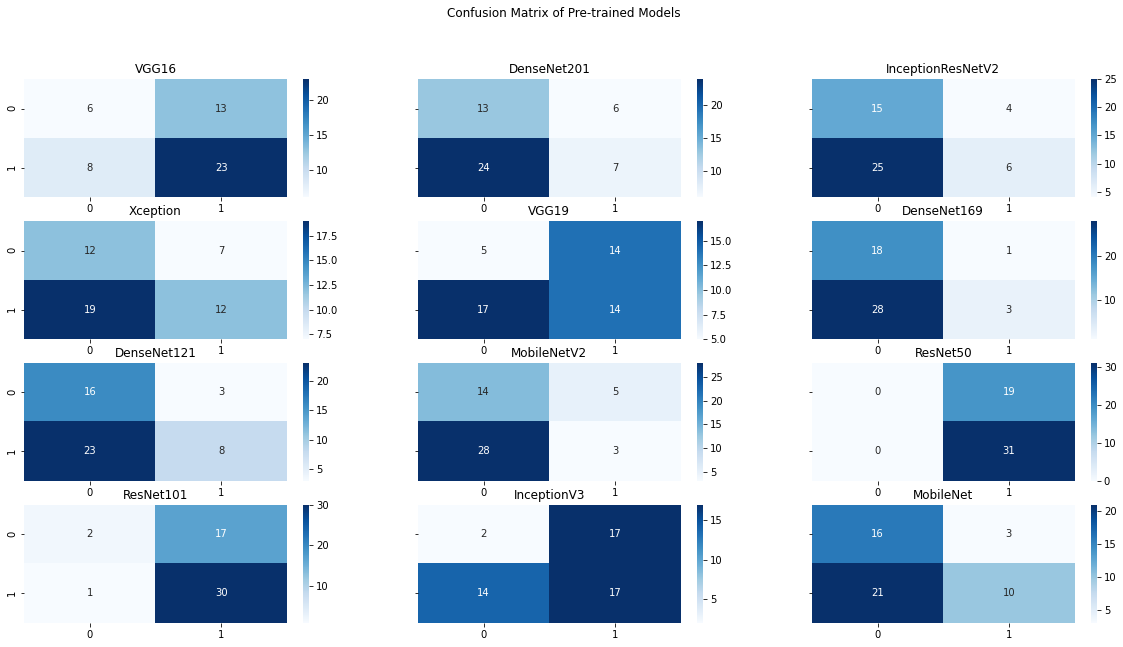

In [27]:
fig, axes = plt.subplots(4, 3, figsize=(20, 10), sharey=True, )
fig.suptitle('Confusion Matrix of Pre-trained Models')
for i, net in enumerate(trained_nets.values()):
    sns.heatmap(nets_evaluation_df.loc[net]['Confusion Matrix'], 
                cmap='Blues', annot=True,ax=axes[i%4, i%3])
    axes[i%4, i%3].set_title(net)

## 8. Custom CNN Models

In [30]:
input_shape = (150, 150, 3)
def model_cnn2():
    
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))

    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))
        
    return model

model_cnn2 = model_cnn2()

In [31]:
def model_cnn3():
    
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))

    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))
        
    return model

model_cnn3 = model_cnn3()

In [32]:
def model_cnn4():
    
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))

    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))
        
    return model

model_cnn4 = model_cnn4()

In [33]:
def model_cnn5():
    
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))

    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))
        
    return model

model_cnn5 = model_cnn5()

In [34]:
def model_cnn6():
    
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))

    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))
        
    return model

model_cnn6 = model_cnn6()


In [35]:
def model_cnn7():
    
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))

    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(256, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))
        
    return model

model_cnn7 = model_cnn7()


In [36]:
def model_cnn8():
    
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))

    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(256, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(256, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))
        
    return model

model_cnn8 = model_cnn8()


In [37]:
custom_models = {model_cnn2 : '2 X CNN', model_cnn3 : '3 X CNN', model_cnn4 : '4 X CNN', model_cnn5 : '5 X CNN',
                model_cnn6 : '6 X CNN', model_cnn7 : '7 X CNN', model_cnn8 : '8 X CNN'}
custom_cnn_evaluation_df = pd.DataFrame(columns=['Training Accuracy', 'Validation Accuracy', 'Test Accuracy', 'F1 Measure', 'Kappa', 'ROC Area'])

In [38]:
for model in custom_models.keys():
    
    model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy'])
    
    history = model.fit(
    train_generator, 
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=len(val_generator))
    
    # validate on test set
    predictions = model.predict(val_generator)
    predictions = [1 if x>0.5 else 0 for x in predictions]

    acc = history.history['accuracy']
    
    val_acc = history.history['val_accuracy']

    test_accuracy = accuracy_score(y_test, predictions)

    kappa_score = cohen_kappa_score(y_test, predictions)

    roc_area = roc_auc_score(y_test, predictions)

    (precision, recall, fscore, support) = precision_recall_fscore_support(y_test, predictions, average='macro')
    
    measures = [acc[-1], val_acc[-1], test_accuracy, fscore, kappa_score, roc_area]

    custom_cnn_evaluation_df.loc[custom_models[model]] = measures

Epoch 1/30
11/11 [==============================] - 2s 197ms/step - loss: 1.6466 - accuracy: 0.6453 - val_loss: 0.6456 - val_accuracy: 0.7000
Epoch 2/30
11/11 [==============================] - 2s 139ms/step - loss: 0.9327 - accuracy: 0.7192 - val_loss: 0.6745 - val_accuracy: 0.7000
Epoch 3/30
11/11 [==============================] - 2s 156ms/step - loss: 1.1770 - accuracy: 0.6798 - val_loss: 0.6260 - val_accuracy: 0.6000
Epoch 4/30
11/11 [==============================] - 2s 163ms/step - loss: 1.0464 - accuracy: 0.7389 - val_loss: 0.6440 - val_accuracy: 0.6400
Epoch 5/30
11/11 [==============================] - 2s 156ms/step - loss: 1.0908 - accuracy: 0.7438 - val_loss: 0.6724 - val_accuracy: 0.6800
Epoch 6/30
11/11 [==============================] - 2s 149ms/step - loss: 0.9558 - accuracy: 0.7143 - val_loss: 0.7253 - val_accuracy: 0.7400
Epoch 7/30
11/11 [==============================] - 2s 147ms/step - loss: 0.9860 - accuracy: 0.7389 - val_loss: 0.6642 - val_accuracy: 0.8200
Epoch 

C:\Users\zeyne\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/30
11/11 [==============================] - 2s 215ms/step - loss: 1.2356 - accuracy: 0.6059 - val_loss: 0.6921 - val_accuracy: 0.4000
Epoch 2/30
11/11 [==============================] - 2s 139ms/step - loss: 1.2442 - accuracy: 0.6256 - val_loss: 0.7052 - val_accuracy: 0.3800
Epoch 3/30
11/11 [==============================] - 2s 155ms/step - loss: 1.2738 - accuracy: 0.6355 - val_loss: 0.6916 - val_accuracy: 0.5400
Epoch 4/30
11/11 [==============================] - 2s 160ms/step - loss: 1.1330 - accuracy: 0.6404 - val_loss: 0.6746 - val_accuracy: 0.6200
Epoch 5/30
11/11 [==============================] - 2s 153ms/step - loss: 1.1045 - accuracy: 0.6749 - val_loss: 0.6769 - val_accuracy: 0.6200
Epoch 6/30
11/11 [==============================] - 2s 160ms/step - loss: 1.0973 - accuracy: 0.6207 - val_loss: 0.6461 - val_accuracy: 0.6200
Epoch 7/30
11/11 [==============================] - 2s 153ms/step - loss: 0.9432 - accuracy: 0.6995 - val_loss: 0.5965 - val_accuracy: 0.6200
Epoch 

C:\Users\zeyne\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/30
11/11 [==============================] - 3s 236ms/step - loss: 1.5296 - accuracy: 0.5813 - val_loss: 0.6892 - val_accuracy: 0.64000s - loss: 1.5891 - accuracy: 
Epoch 2/30
11/11 [==============================] - 2s 147ms/step - loss: 1.2790 - accuracy: 0.5369 - val_loss: 0.6665 - val_accuracy: 0.6200
Epoch 3/30
11/11 [==============================] - 2s 167ms/step - loss: 1.2972 - accuracy: 0.6305 - val_loss: 0.6753 - val_accuracy: 0.6200
Epoch 4/30
11/11 [==============================] - 2s 166ms/step - loss: 0.9522 - accuracy: 0.6453 - val_loss: 0.6686 - val_accuracy: 0.6200
Epoch 5/30
11/11 [==============================] - 2s 168ms/step - loss: 0.9507 - accuracy: 0.6946 - val_loss: 0.6894 - val_accuracy: 0.6200
Epoch 6/30
11/11 [==============================] - 2s 165ms/step - loss: 1.0775 - accuracy: 0.6404 - val_loss: 0.8998 - val_accuracy: 0.6200
Epoch 7/30
11/11 [==============================] - 2s 167ms/step - loss: 0.8502 - accuracy: 0.7192 - val_loss: 0.8841

C:\Users\zeyne\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/30
11/11 [==============================] - 3s 270ms/step - loss: 1.1062 - accuracy: 0.5961 - val_loss: 0.6924 - val_accuracy: 0.3800
Epoch 2/30
11/11 [==============================] - 2s 154ms/step - loss: 1.1693 - accuracy: 0.6158 - val_loss: 0.6916 - val_accuracy: 0.3800
Epoch 3/30
11/11 [==============================] - 2s 167ms/step - loss: 0.9045 - accuracy: 0.7340 - val_loss: 0.6825 - val_accuracy: 0.6200
Epoch 4/30
11/11 [==============================] - 2s 171ms/step - loss: 0.9653 - accuracy: 0.6847 - val_loss: 0.6854 - val_accuracy: 0.6200
Epoch 5/30
10/11 [==========================>...] - ETA: 0s - loss: 1.3754 - accuracy: 0.6612

ResourceExhaustedError:  OOM when allocating tensor with shape[20,64,75,75] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradients_29/SquaredDifference_4276_grad/mul_1-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_822586]

Function call stack:
keras_scratch_graph


In [39]:
custom_cnn_evaluation_df

,Training Accuracy,Validation Accuracy,Test Accuracy,F1 Measure,Kappa,ROC Area
2 X CNN,0.733990,0.82,0.54,0.494505,-0.007005,0.496604
3 X CNN,0.738916,0.62,0.62,0.382716,0.000000,0.500000
4 X CNN,0.714286,0.62,0.62,0.382716,0.000000,0.500000
5 X CNN,0.704434,0.62,0.62,0.382716,0.000000,0.500000


In [40]:
nets_evaluation_df = pd.concat([custom_cnn_evaluation_df, nets_evaluation_df])

In [41]:
nets_evaluation_df.to_excel("nets_evaluation.xlsx")

In [42]:
nets_evaluation_df

,Training Accuracy,Validation Accuracy,Test Accuracy,F1 Measure,Kappa,ROC Area,Confusion Matrix
2 X CNN,0.733990,0.82,0.54,0.494505,-0.007005,0.496604,NaN
3 X CNN,0.738916,0.62,0.62,0.382716,0.000000,0.500000,NaN
4 X CNN,0.714286,0.62,0.62,0.382716,0.000000,0.500000,NaN
5 X CNN,0.704434,0.62,0.62,0.382716,0.000000,0.500000,NaN
VGG16,0.778325,0.78,0.58,0.525102,0.060823,0.528862,"[[6, 13], [8, 23]]"
VGG19,0.793103,0.82,0.38,0.359239,-0.276771,0.357385,"[[5, 14], [17, 14]]"
ResNet50,0.906404,0.62,0.62,0.382716,0.000000,0.500000,"[[0, 19], [0, 31]]"
ResNet101,0.891626,0.60,0.64,0.475524,0.087221,0.536503,"[[2, 17], [1, 30]]"
DenseNet201,0.896552,0.64,0.40,0.391234,-0.076040,0.455008,"[[13, 6], [24, 7]]"
DenseNet169,0.876847,0.46,0.42,0.362637,0.034621,0.522071,"[[18, 1], [28, 3]]"
